In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import string
from keras.datasets import imdb

In [2]:
os.environ['KAGGLE_USERNAME'] = "aadityakomerwar" 
os.environ['KAGGLE_KEY'] = "fd6ffd09e5076d4f9170ecd7636787ef"

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

100% 25.7M/25.7M [00:02<00:00, 21.5MB/s]
100% 25.7M/25.7M [00:02<00:00, 12.4MB/s]


In [4]:
!mkdir dataset

In [5]:
!unzip -q imdb-dataset-of-50k-movie-reviews.zip -d dataset/

In [6]:
!mv dataset/"IMDB Dataset.csv" dataset/IMDB_Dataset.csv

In [7]:
!rm  -f imdb-dataset-of-50k-movie-reviews.zip

In [8]:
raw_data_df = pd.read_csv('dataset/IMDB_Dataset.csv')

In [9]:
raw_data_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
raw_data_df['sentiment'] = raw_data_df['sentiment'].apply(lambda row : 1 if row == 'positive' else 0)

In [ ]:
raw_data_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
len(raw_data_df[raw_data_df['sentiment'] == 1])

25000

In [ ]:
len(raw_data_df[raw_data_df['sentiment'] == 0])

25000

In [ ]:
features = raw_data_df['review'].to_numpy()
labels = raw_data_df['sentiment'].to_numpy()

In [ ]:
features.shape

(50000,)

In [ ]:
labels.shape

(50000,)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.4, random_state = 0)

In [ ]:
features_valid, features_test, labels_valid, labels_test = train_test_split(features_test, labels_test, test_size=0.5, random_state=0)

In [ ]:
features_train = tf.convert_to_tensor(features_train)
labels_train = tf.convert_to_tensor(labels_train)

In [ ]:
features_valid = tf.convert_to_tensor(features_valid)
labels_valid = tf.convert_to_tensor(labels_valid)

In [ ]:
features_test = tf.convert_to_tensor(features_test)
labels_test = tf.convert_to_tensor(labels_test)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((features_train, labels_train))
next(iter(train_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b'Liked Stanley & Iris very much. Acting was very good. Story had a unique and interesting arrangement. The absence of violence and porno sex was refreshing. Characters were very convincing and felt like you could understand their feelings. Very enjoyable movie.'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [ ]:
valid_ds = tf.data.Dataset.from_tensor_slices((features_valid, labels_valid))
next(iter(valid_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b'This version of "The Magic Flute" is not only the worst production of Mozart\'s great opera that I have ever seen, it is also the worst video production I have seen of any opera.<br /><br />I\'m a big opera fan and I have more opera on DVD than movies. The sets are cheap and cheesy. Papageno doesn\'t even have a bird costume. He is just dressed like some guy. The sound is in mono. The color is really bad. It is saturated in orange. Most DVD\'s from this period have the color digitally restored, but they did not bother with this one. Also, the language has been changed to Swedish instead of the original German.<br /><br />This is not a movie version of "The Magic Flute." It is a filmed performance and it is not a good performance and it was not filmed very well. You can pick any other available DVD of this opera and I guarantee it will be better than this one. My preference is for the version conducted by James Levine with sets by David Hockn

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((features_test, labels_test))
next(iter(test_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b"Leslie Nielson is a very talented actor, who made a huge mistake by doing this film. It doesn't even come close to being funny. The best word to describe it is STUPID!">,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE)
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=469>

In [ ]:
valid_ds = valid_ds.batch(batch_size=BATCH_SIZE)
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=469>

In [ ]:
test_ds = test_ds.batch(batch_size=BATCH_SIZE)
test_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=157>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def custom_standardization(input_data):
  std_text = tf.strings.lower(input_data)#remove any urls from the text
  std_text = tf.strings.regex_replace(std_text, r"https:\/\/.*[\r\n]*", '')
  std_text = tf.strings.regex_replace(std_text, r"www\.\w*\.\w\w\w", '')
  std_text = tf.strings.regex_replace(std_text, r"<[\w]*[\s]*/>", '')
  std_text = tf.strings.regex_replace(std_text, '[%s]' % re.escape(string.punctuation), '')
  std_text = tf.strings.regex_replace(std_text, '\s{2}', '')
  std_text = tf.strings.strip(std_text)
  return std_text

In [ ]:
custom_standardization("Hello ! <br /> I am here. Why are you upset ?").numpy()

b'hello i am here why are you upset'

In [ ]:
VOCAB_SIZE = 1000

In [ ]:
vectorizer_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE,
                                                                                standardize=custom_standardization)
                                                                                #output_mode='tf_idf')

In [ ]:
vectorizer_layer.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(vectorizer_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it',
       'this', 'i', 'that', 'was', 'as', 'with', 'for', 'movie', 'but',
       'film'], dtype='<U14')

In [ ]:
examples, labels = next(iter(train_ds.take(1)))

In [ ]:
examples[ : 3]

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Liked Stanley & Iris very much. Acting was very good. Story had a unique and interesting arrangement. The absence of violence and porno sex was refreshing. Characters were very convincing and felt like you could understand their feelings. Very enjoyable movie.',
       b"The Mummy's Curse is the last in the series of the Kharis mummy films, and it seems that creativity had run somewhat dry by the time they made this one. Kharis and his mate Ananka both end up in the bayous of Louisiana, and on his resurrection, he searches out his beloved princess. How they end up in Louisiana isn't made entirely clear, but with various people trying to find them, the viewer can be assured of some mummy murders.<br /><br />The Mummy's Curse was watchable, but it really wasn't anything special. I had the feeling throughout the movie that I'd seen this before. Quite frankly, apart from the original The Mummy with Boris Karloff, the Mummy movies are no

In [ ]:
vectorized_examples = vectorizer_layer(examples)

In [ ]:
vectorized_examples.shape

TensorShape([64, 856])

In [ ]:
vectorized_examples[ : 3]

<tf.Tensor: shape=(3, 856), dtype=int64, numpy=
array([[410,   1,  51, ...,   0,   0,   0],
       [  2,   1,   1, ...,   0,   0,   0],
       [114,   8, 118, ...,   0,   0,   0]])>

In [ ]:
examples.shape

TensorShape([64])

In [ ]:
model = tf.keras.Sequential([ vectorizer_layer,
                              tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                              tf.keras.layers.Dense(64, activation = 'relu'),
                              tf.keras.layers.Dense(1, ) ])

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.00099148]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

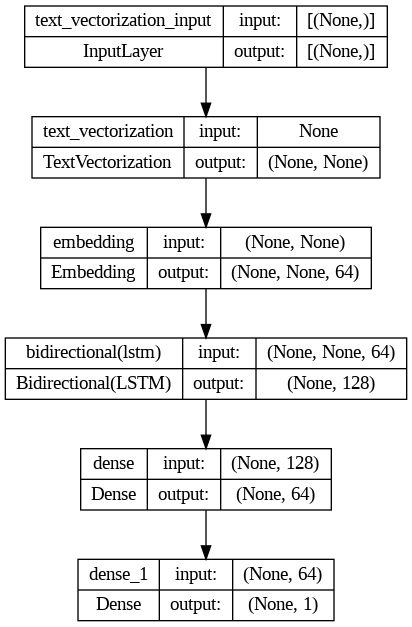

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=valid_ds)

Epoch 1/10
469/469 [==============================] - 57s 98ms/step - loss: 0.6372 - accuracy: 0.5672 - val_loss: 0.4449 - val_accuracy: 0.7708
Epoch 2/10
469/469 [==============================] - 30s 63ms/step - loss: 0.3885 - accuracy: 0.8217 - val_loss: 0.3666 - val_accuracy: 0.8361
Epoch 3/10
469/469 [==============================] - 30s 64ms/step - loss: 0.3355 - accuracy: 0.8547 - val_loss: 0.3501 - val_accuracy: 0.8455
Epoch 4/10
469/469 [==============================] - 30s 64ms/step - loss: 0.3197 - accuracy: 0.8636 - val_loss: 0.3461 - val_accuracy: 0.8479
Epoch 5/10
469/469 [==============================] - 30s 64ms/step - loss: 0.3136 - accuracy: 0.8657 - val_loss: 0.3444 - val_accuracy: 0.8509
Epoch 6/10
469/469 [==============================] - 30s 64ms/step - loss: 0.3088 - accuracy: 0.8686 - val_loss: 0.3445 - val_accuracy: 0.8523
Epoch 7/10
469/469 [==============================] - 30s 63ms/step - loss: 0.3065 - accuracy: 0.8703 - val_loss: 0.3459 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 5s 29ms/step - loss: 0.3351 - accuracy: 0.8561
Test Loss: 0.3350614011287689
Test Accuracy: 0.8561000227928162


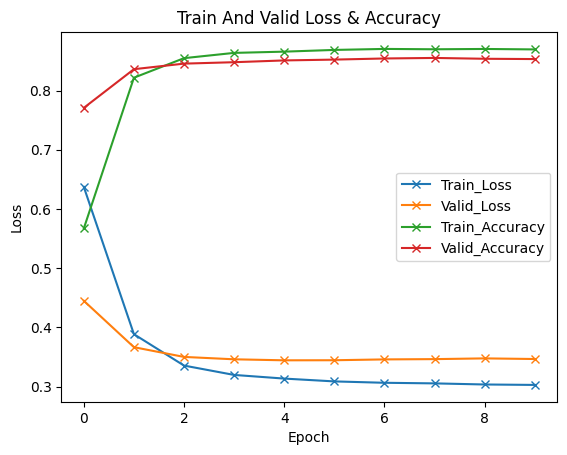

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], "x-", label="Train_Loss")
plt.plot(history.history["val_loss"], "x-", label="Valid_Loss")
plt.plot(history.history["accuracy"], "x-", label="Train_Accuracy")
plt.plot(history.history["val_accuracy"], "x-", label="Valid_Accuracy")
plt.title("Train And Valid Loss & Accuracy")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
